### SNR requirement

A general SNR model has too many degrees of freedom to be used unconstrained for requirement analyses. Therefore, SNR analysis is based on the following idea:
* We assume the TANGO L1B reference scene $I_\mathrm{ref}$ simulated for an albedo of 0.15 and a SZA of 70 degree
* The SNR spectrum can be approximately described by
    $\mathrm{SNR}(\lambda) = \frac{a(\lambda)\; I_\mathrm{ref}}{ a(\lambda)\; I_\mathrm{ref} + b(\lambda) }$
* We assume that b is given by our instrument model acounting for the signal independent contribution of the SNR spectrum. 
* Varying $a$ changes the SNR, and we aim to derive a requirement of $a$ for a realistic estimate of $b$. 
* $a$ may vary in the spectral dimension and so we need a physical model to constrain this dependence. We derive SNR spectra by scaling $a(\lambda)$ with a constant factor $s$, thus
    $\mathrm{SNR}(\lambda,s) = \frac{a(\lambda)\;s\; I_\mathrm{ref}}{ a(\lambda)\; s\;I_\mathrm{ref} + b(\lambda) }$
* For a non-scattering atmosphere, the scaling factor can be absorbed in a scaled surface albedo. So, we calculate $$\mathrm{SNR}(\lambda,s)$ scaling the Lambertian albedo $A_s$ by
    $A_\mathrm{ref} \to A(s) = s \;A_\mathrm{ref}$
* Next, we derive the L2 precision for an L1B input $I_\mathrm{ref}$ and $\mathrm{SNR}(\lambda,s)$ as a function of $s$. Note that the radiance spectrum remains unchanged.
* We consider the median performance of all ACT position using a referencee ckd set 
* To formulate the requirement such that it constrains both the scaling factor $s$ and the assumed signal independent term $b$, we derive the mean SNR over the two fit windows 1597.0-1617.0 nm and 1664.4-1668.0 nm.
* Having a requirement on the L2 precision of 3.8 ppm for the reference scene, we can derive the scaling factor, and so the required mean SNR for the fit windows. 
* Finally, the resilence of the approach with respect to dead and bad pixels will be tested. 

#### 1. Set working enviroment

In [1]:
import sys
sys.path.append("/home/jochen/pythonenvs/tangoendtoend/lib64/python3.11/site-packages")
import os
import yaml
import numpy as np
from netCDF4 import Dataset
import matplotlib
# define  path to search for module
sys.path.append("/home/jochen/TANGO_E2ES/EndtoEndProject/end_to_end/")
os.chdir("/home/jochen/TANGO_E2ES/EndtoEndProject/end_to_end/examples/exp5_snr/")

#### 2. import teds modules

In [2]:
from teds.gm import geometry_module
from teds.sgm import geoscene_generation
from teds.sgm import Carbon_radiation_scene_generation
from teds.im import run_instrument_model
from teds.l1al1b import run_l1al1b
from teds.l1l2.l1bl2 import level1b_to_level2_processor_RTorCH4, level1b_to_level2_processor
from teds.lib.libNumTools import get_isrf
from examples.exp5_snr.l1b_pixel_mask import combined_l1b

#### 3. Operational flags

In [3]:
proc_gm     = False
proc_sgmgeo = False
proc_sgmrad = False
proc_im     = False
proc_l1al1b = False
proc_l1bl2  = True

data_alys   = True 

proc_req_res= False

Set variables applicable to all cells

In [4]:
path  = '/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/'
nsca  = 40
scale = np.arange(nsca)*0.05 + 0.05 #radiance scaling 
#nsca  = 1
#scale = np.arange(nsca)*1.0 #radiance scaling 


In [5]:
if(proc_gm):
    #configureation file
    #In this case, the gm does not include solar and viewing geometry. It is easier to define them with the notebook
    gm_config= yaml.safe_load(open('./settings/gm_config.yaml'))
    #we use the nact dimension to simulate scenes with different scaling factors s and the geometry of Lref
    nact = 100 
    gm_config['scene_spec'] = {}
    gm_config['scene_spec']['sza'] = np.zeros(nact) + 70.
    gm_config['scene_spec']['saa'] = np.zeros(nact) 
    gm_config['scene_spec']['vza'] = np.zeros(nact) 
    gm_config['scene_spec']['vaa'] = np.zeros(nact) 

    geometry_module(gm_config)


#### 5. SGM-GEO

Here we make use of the fact that for a non-scattering RT simulation a scaling of the radiance spectrum is equivalent with a scaling of the albedo.

In [6]:
if(proc_sgmgeo):
    albedo = np.ones(nact)*0.15
    for sc in scale:
        sgmgeo_config= yaml.safe_load(open('./settings/sgmgeo_config.yaml'))
        sgmgeo_config['scene_spec']={}
        sgmgeo_config['scene_spec']['albedo'] = albedo*sc
        sgmgeo_config['io_files']['output_geo']=path+'sgm/Tango_Carbon_sgm_atmosphere_exp5.0_scale_'+("%.3f" % (sc)) + '.nc'
        geoscene_generation(sgmgeo_config)

#### 6. SGM-RAD

In [7]:
if(proc_sgmrad):

    for sc in scale:
        sgmrad_config= yaml.safe_load(open('./settings/sgmrad_config.yaml'))
        sgmrad_config['io_files']['input_sgm_geo']=path+'sgm/Tango_Carbon_sgm_atmosphere_exp5.0_scale_'+("%.3f" % (sc)) + '.nc'
        sgmrad_config['io_files']['output_rad']=path + 'sgm/Tango_Carbon_sgm_radiance_exp5.0_scale_'+("%.3f" % (sc)) + '.nc'
        Carbon_radiation_scene_generation(sgmrad_config)

### 7. Instrument model 

Run the instrument model for each scaled scenes using a seperate call 

In [8]:
if(proc_im):

    for sc in scale:
        im_config= yaml.safe_load(open('./settings/im_config.yaml'))
        im_config['io']['sgm'] = path + 'sgm/Tango_Carbon_sgm_radiance_exp5.0_scale_'+("%.3f" % (sc)) + '.nc'
        im_config['io']['l1a'] = path + 'level1a/Tango_Carbon_l1a_exp5.0_scale_'+("%.3f" % (sc)) + '.nc'
        run_instrument_model(im_config)

#### 8. L1B processing

In [9]:
if(proc_l1al1b):
    for sc in scale:
        l1al1b_config= yaml.safe_load(open('./settings/l1al1b_config.yaml'))
        l1al1b_config['io']['l1a'] = path + 'level1a/Tango_Carbon_l1a_exp5.0_scale_'+("%.3f" % (sc)) + '.nc'
        l1al1b_config['io']['l1b'] = path + 'level1b/Tango_Carbon_l1b_exp5.0_scale_'+("%.3f" % (sc)) + '.nc'
        run_l1al1b(l1al1b_config)

#### 8. L2 processing of the $\mathrm{CO_2}$ and $\mathrm{CH_4}$ proxy product

* First reference simulation with gain simulations
* Loop over different isrf perturbations (acoeff and bcoeff of the generalized normal distribution)

In [10]:
if(proc_l1bl2):

    for sc in scale:
        l1b_ref   = path + 'level1b/Tango_Carbon_l1b_exp5.0_scale_1.000.nc'
        l1b_scale = path + 'level1b/Tango_Carbon_l1b_exp5.0_scale_'+("%.3f" % (sc)) + '.nc'
        l1b_comb  = path + 'level1b/Tango_Carbon_l1b_exp5.0_comb_'+("%.3f" % (sc)) + '.nc'
        combined_l1b(l1b_ref, l1b_scale, l1b_comb)
        
        l1bl2_config= yaml.safe_load(open('./settings/l1bl2_config.yaml'))
        l1bl2_config['io_files']['input_l1b'] = l1b_comb
        l1bl2_config['io_files']['output_l2'] = path + 'level2/Tango_Carbon_l2_exp5.0_scale_'+("%.3f" % (sc)) + '.nc'
        level1b_to_level2_processor(l1bl2_config)


=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [02:02<00:00, 122.59s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_0.050.nc
=> l1bl2 finished successfully
=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [01:38<00:00, 98.76s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_0.100.nc
=> l1bl2 finished successfully
=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [01:37<00:00, 97.09s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_0.150.nc
=> l1bl2 finished successfully
=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [01:50<00:00, 110.45s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_0.200.nc
=> l1bl2 finished successfully
=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [01:46<00:00, 106.76s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_0.250.nc
=> l1bl2 finished successfully
=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [01:46<00:00, 106.60s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_0.300.nc
=> l1bl2 finished successfully
=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [01:56<00:00, 116.58s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_0.350.nc
=> l1bl2 finished successfully
=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [01:56<00:00, 116.01s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_0.400.nc
=> l1bl2 finished successfully
=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [01:56<00:00, 116.53s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_0.450.nc
=> l1bl2 finished successfully
=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [01:56<00:00, 116.36s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_0.500.nc
=> l1bl2 finished successfully
=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [01:57<00:00, 117.81s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_0.550.nc
=> l1bl2 finished successfully
=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [01:55<00:00, 115.83s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_0.600.nc
=> l1bl2 finished successfully
=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [01:56<00:00, 116.86s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_0.650.nc
=> l1bl2 finished successfully
=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [01:56<00:00, 116.42s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_0.700.nc
=> l1bl2 finished successfully
=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [01:56<00:00, 116.33s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_0.750.nc
=> l1bl2 finished successfully
=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [01:57<00:00, 117.19s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_0.800.nc
=> l1bl2 finished successfully
=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [02:03<00:00, 123.42s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_0.850.nc
=> l1bl2 finished successfully
=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [02:06<00:00, 126.11s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_0.900.nc
=> l1bl2 finished successfully
=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [02:08<00:00, 128.96s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_0.950.nc
=> l1bl2 finished successfully
=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [02:06<00:00, 126.43s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_1.000.nc
=> l1bl2 finished successfully
=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [02:05<00:00, 125.57s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_1.050.nc
=> l1bl2 finished successfully
=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [02:03<00:00, 123.63s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_1.100.nc
=> l1bl2 finished successfully
=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [02:05<00:00, 125.60s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_1.150.nc
=> l1bl2 finished successfully
=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [02:06<00:00, 126.26s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_1.200.nc
=> l1bl2 finished successfully
=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [02:05<00:00, 125.90s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_1.250.nc
=> l1bl2 finished successfully
=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [02:05<00:00, 125.57s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_1.300.nc
=> l1bl2 finished successfully
=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [02:07<00:00, 127.01s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_1.350.nc
=> l1bl2 finished successfully
=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [02:06<00:00, 126.60s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_1.400.nc
=> l1bl2 finished successfully
=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [02:05<00:00, 125.36s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_1.450.nc
=> l1bl2 finished successfully
=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [02:05<00:00, 125.51s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_1.500.nc
=> l1bl2 finished successfully
=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [02:04<00:00, 124.72s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_1.550.nc
=> l1bl2 finished successfully
=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [02:06<00:00, 126.69s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_1.600.nc
=> l1bl2 finished successfully
=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [02:05<00:00, 125.58s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_1.650.nc
=> l1bl2 finished successfully
=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [02:02<00:00, 122.49s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_1.700.nc
=> l1bl2 finished successfully
=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [02:03<00:00, 123.67s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_1.750.nc
=> l1bl2 finished successfully
=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [02:04<00:00, 124.76s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_1.800.nc
=> l1bl2 finished successfully
=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [02:03<00:00, 123.31s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_1.850.nc
=> l1bl2 finished successfully
=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [02:03<00:00, 123.18s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_1.900.nc
=> l1bl2 finished successfully
=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [02:04<00:00, 124.67s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_1.950.nc
=> l1bl2 finished successfully
=> l1b data combined successfully 
level 1B to 2 proessor ...


100%|██████████| 1/1 [02:02<00:00, 122.44s/it]

/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_scale_2.000.nc
=> l1bl2 finished successfully


#### 9. Data analysis: SNR requirement

9.1 Read in data and calculate the mean SNR and radiance for the two spectral windows wave1 $\pm$ 10 nm and wave2 $\pm$ 1.8 nm.

0 0.05 35.565395505903744 2.69626584411808e+16 47.026666667932474
1 0.1 68.30495141105226 2.69626584411808e+16 24.320489503260127
2 0.15000000000000002 99.23708317932616 2.69626584411808e+16 16.722282645013173
3 0.2 128.23552465805375 2.69626584411808e+16 12.905488243263985
4 0.25 155.7372019280768 2.69626584411808e+16 10.611933398962051
5 0.3 181.76804647960876 2.69626584411808e+16 9.074585383272193
6 0.35000000000000003 206.20385442802046 2.69626584411808e+16 7.968350185013218
7 0.4 229.57451971423353 2.69626584411808e+16 7.135311603355541
8 0.45 251.77605069008825 2.69626584411808e+16 6.484000594884537
9 0.5 273.0347644367843 2.69626584411808e+16 5.959943183582673
10 0.55 293.4735174839142 2.69626584411808e+16 5.529207120705195
11 0.6000000000000001 313.1652677351087 2.69626584411808e+16 5.168527088668664
12 0.6500000000000001 332.42271032803956 2.69626584411808e+16 4.8613409184007015
13 0.7000000000000001 351.24518241534247 2.69626584411808e+16 4.59572902887866
14 0.750000000000000

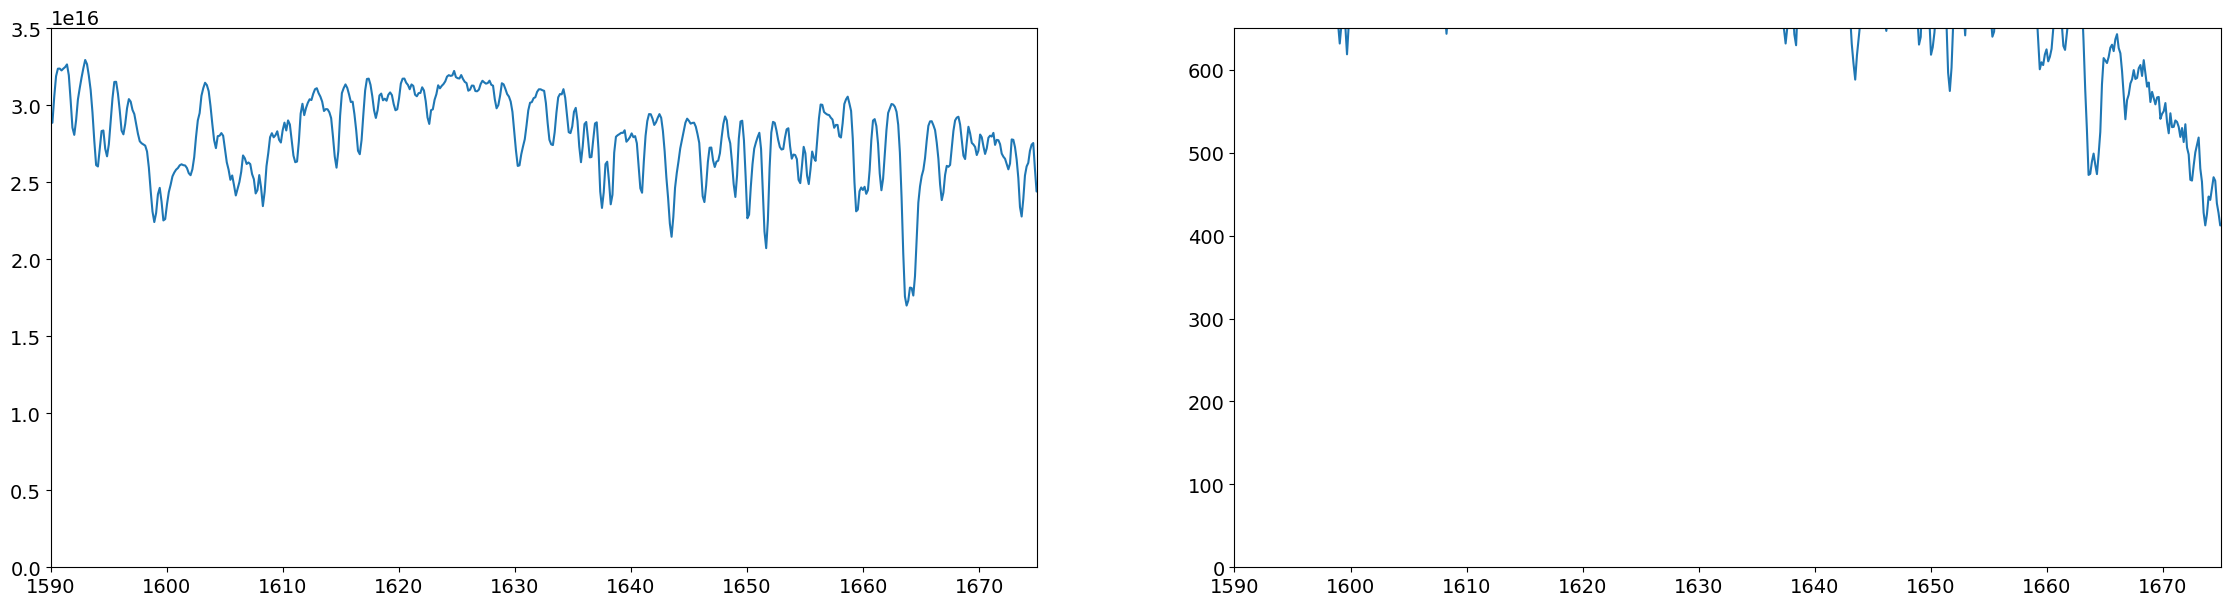

In [27]:
if(data_alys):
    import netCDF4 as nc
    import numpy as np
    from copy import deepcopy
    import matplotlib.pyplot as plt
    import sys
    plt.rcParams.update({'font.size': 14,})
    path ='/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/'

    # Define spectral boundaries of the two windows in requirement MRD-L1B-0140
    wave1 = 1607.0
    wave2 = 1666.2
    wave1_ini = wave1-10.
    wave1_fin = wave1+10.
    wave2_ini = wave2-1.8
    wave2_fin = wave2+1.8

    snr_max= np.zeros((nsca))
    snr_min= np.zeros((nsca))
    rad_max= np.zeros((nsca))
    rad_min= np.zeros((nsca))

    snr_w1= np.zeros((nsca))
    snr_w2= np.zeros((nsca))
    rad_w1= np.zeros((nsca))
    rad_w2= np.zeros((nsca))
    
    l2prec_median = np.zeros((nsca))
    alb_median = np.zeros((nsca))
    co2 = np.zeros((nsca))

    for isca, sc in enumerate(scale):
        #print(isca, sc)
        filenamel1b = path + 'level1b/Tango_Carbon_l1b_exp5.0_comb_'+("%.3f" % (sc)) + '.nc'
        filenamel2  = path + 'level2/Tango_Carbon_l2_exp5.0_scale_'+("%.3f" % (sc)) + '.nc'

        l1b_data = nc.Dataset(filenamel1b)
        l2_data  = nc.Dataset(filenamel2)

        wave  = np.array(deepcopy(l1b_data['observation_data']['wavelength'][:]))
        rad   = np.array(deepcopy(l1b_data['observation_data']['radiance'][:]))
        noise = np.array(deepcopy(l1b_data['observation_data']['radiance_stdev'][:]))
        snr = rad/noise

        nalt, nact, nwave = rad.shape
        # Start with the mean snr in teo predefined spectral windows
        snr_1 = np.zeros([nalt,nact])
        snr_2 = np.zeros([nalt,nact])
        rad_1 = np.zeros([nalt,nact])
        rad_2 = np.zeros([nalt,nact])

        # Because of smile the detector position of the spectral windows changes with iact index  
        for ialt in range(nalt):
            for iact in range(nact):
                l1_ini = (np.absolute(wave[iact,:]-wave1_ini)).argmin()
                l1_fin = (np.absolute(wave[iact,:]-wave1_fin)).argmin()

                l2_ini = (np.absolute(wave[iact,:]-wave2_ini)).argmin()
                l2_fin = (np.absolute(wave[iact,:]-wave2_fin)).argmin()
        
                snr_1[ialt,iact]  = np.mean(snr[ialt,iact,l1_ini:l1_fin])
                snr_2[ialt,iact]  = np.mean(snr[ialt,iact,l2_ini:l2_fin])

                rad_1[ialt,iact]  = np.mean(snr[ialt,iact,l1_ini:l1_fin])
                rad_2[ialt,iact]  = np.mean(snr[ialt,iact,l2_ini:l2_fin])

        snr_w1[isca] = np.median(snr_1) 
        snr_w2[isca] = np.median(snr_2)
        rad_w1[isca] = np.median(rad_1) 
        rad_w2[isca] = np.median(rad_2)

        # previous approach with fixed wavelength
        wave1 = 1605.78
        wave1 = 1603
        wave2 = 1665.80
        lmax = (np.absolute(wave[0,:]-wave1)).argmin()
        lmin = (np.absolute(wave[0,:]-wave2)).argmin()

        snr_w1[isca] = np.median(snr[0,:,lmax]) 
        snr_w2[isca] = np.median(snr[0,:,lmin])
        rad_w1[isca] = np.median(rad[0,:,lmax]) 
        rad_w2[isca] = np.median(rad[0,:,lmin])
    
        prec_xco2_proxy = np.array(deepcopy(l2_data['precision XCO2 proxy'][:]).flatten())
        l2alb = np.array(deepcopy(l2_data['albedo'][:]).flatten())
        l2prec_median[isca] = np.median(prec_xco2_proxy)
        alb_median[isca] = np.median(l2alb)

        print(isca, scale[isca],snr_w1[isca], rad_w1[isca], l2prec_median[isca])
    # EoL the requirement on the L2 precision is 3.8 ppm. Using linear interpolation, 
    # we determine the correspsonding mean SNR and mean radiance for the two fit windows
     
    l2_req   = 3.8

    req_snr_w1 = np.interp(l2_req, np.flip(l2prec_median[:]), np.flip(snr_w1[:]))
    req_snr_w2 = np.interp(l2_req, np.flip(l2prec_median[:]), np.flip(snr_w2[:]))

    req_rad_w1 = np.interp(l2_req, np.flip(l2prec_median[:]), np.flip(rad_w1[:]))
    req_rad_w2 = np.interp(l2_req, np.flip(l2prec_median[:]), np.flip(rad_w2[:]))

    sw_fig1 = True
    sw_fig2 = False

    if(sw_fig1):
        fig = plt.figure(figsize=(28, 7), dpi=100,)
        ax0 = fig.add_subplot(121)
        print('albedo = ', alb_median[isca])
        ax0.plot(wave[0,:], rad[0,50,:])
        ax0.set_ylim([0.0,3.5E16])
        ax0.set_xlim([1590,1675])
        ax1 = fig.add_subplot(122)
        ax1.plot(wave[0,:], snr[0,50,:])
        ax1.set_xlim([1590,1675])
        ax1.set_ylim([0.0,650])
    
    if(sw_fig2):
        fig = plt.figure(figsize=(15, 7), dpi=100,)
        #define text boxes with derived requirement   
        textstr_max = '\n'.join((
            r'$\lambda_1=%.2f$' % (wave1, ) + 'nm',
            r'$I_1=%.2E$' % (req_rad_w1, ) + ' ph/(s sr m$^2$ nm)',
            r'$SNR_1=%.2f$' % (req_snr_w1, )))
        
        textstr_min = '\n'.join((
            r'$\lambda_2=%.2f$' % (wave2, ) + 'nm',
            r'$I_2=%.2E$' % (req_rad_w2, ) + ' ph/(s sr m$^2$ nm)',
            r'$SNR_2=%.2f$' % (req_snr_w2, )))
        
        ax1 = fig.add_subplot(111)
        ax1.plot(l2prec_median,snr_w1, color = 'green', label = 'SNR$_\mathrm{w1}$')
        ax1.plot(l2prec_median,snr_w2, color = 'blue', label = 'SNR$_\mathrm{w2}$')
        ax1.set_xlabel('XCO$_2^\mathrm{prox}$ [ppm]')
        ax1.set_ylabel('SNR [1]')
        plt.legend()
        props = dict(boxstyle='round', facecolor='green', alpha=0.2)
        ax1.text(0.15, 0.95, textstr_max, transform=ax1.transAxes, fontsize=14,
                verticalalignment='top', bbox=props)
        props = dict(boxstyle='round', facecolor='blue', alpha=0.2)
        ax1.text(0.15, 0.65, textstr_min, transform=ax1.transAxes, fontsize=14,
                verticalalignment='top', bbox=props)
#     plt.savefig('plots/snr.png',)
    

### 10. Resilence of SNR requirement with respect to a variable number of dead and bad pixels

The aim of this analysis is to show that with an increased number of randomly distributed dead/bad pixels both the mean radiance and SNR over the two fit window changes such that the requirement still holds. For this purpose, we consider a loss of up to 10 % of all spectral pixels. The analysis is based on the simulated L1B spectra. We do not consider L1A pixel masks as this assumes already a handling of dead pixels in a binning scheme. 

In [12]:
if(proc_req_res):
   import netCDF4 as nc
   import numpy as np
   from copy import deepcopy
   import matplotlib.pyplot as plt

   from examples.exp5_snr.l1b_pixel_mask import random_pixel_mask, get_l1b, sim_modified_output
   filen_l1b  = path + 'level1b/Tango_Carbon_l1b_exp5.0_scale_1.000.nc'

   dead_pixel_range = np.array([0,2,4,6,8,10])*0.01
   for pm_seed, frac_dead_pixels in enumerate(dead_pixel_range):
      filen_l1b_pm = path + 'level1b/Tango_Carbon_l1b_exp5.0_scale_1.000_pm'+ "{:.4f}".format(frac_dead_pixels)+'.nc'
      random_pixel_mask(filen_l1b, filen_l1b_pm, frac_dead_pixels, pm_seed)
      # #check 
      # l1b = get_l1b(filen_l1b_pm)
      # nalt, nact, nwave = l1b['radiance'].shape
      # print(l1b['mask'].sum()/(nalt*nact*nwave))

      l1bl2_config= yaml.safe_load(open('./settings/l1bl2_config.yaml'))
      l1bl2_config['io_files']['input_l1b'] = filen_l1b_pm
      l1bl2_config['io_files']['output_l2'] = path + 'level2/Tango_Carbon_l2_exp5.0_scale_'+("%.3f" % (sc)) + '.nc'
      level1b_to_level2_processor(l1bl2_config)
